In [1]:
import numpy as np
import pandas as pd
import obspy
import glob
import os
import re
import csv
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from collections import defaultdict

%matplotlib inline

Download `data` folder with the appropriate subfolders (`lunar` and `mars`) in the root directory of this project.

In [2]:
def get_mseed_files_list(path):
    return glob.glob(f"{path}/**/*.mseed", recursive=True)

def remove_evid_suffix(name):
    if match := re.match(r"(.*)_evid\d+(?:\.(?:csv|mseed))?", name):
        return match.group(1)

lunar_train_data_dir = "./data/lunar/training/data"
lunar_test_data_dir = "./data/lunar/test/data"

mars_train_data_dir = "./data/mars/training/data"
mars_test_data_dir = "./data/mars/test/data"

lunar_train_data_file_paths = get_mseed_files_list(lunar_train_data_dir)
lunar_test_data_file_paths = get_mseed_files_list(lunar_test_data_dir)

mars_train_data_file_paths = get_mseed_files_list(mars_train_data_dir)
mars_test_data_file_paths = get_mseed_files_list(mars_test_data_dir)

train_data_file_paths = lunar_train_data_file_paths + mars_train_data_file_paths
test_data_file_paths = lunar_test_data_file_paths + mars_test_data_file_paths

assert len(lunar_train_data_file_paths) > 0
assert len(lunar_test_data_file_paths) > 0
assert len(mars_train_data_file_paths) > 0
assert len(mars_test_data_file_paths) > 0

In [3]:
lunar_catalog_path = "./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
mars_catalog_path = "./data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"

lunar_catalog = pd.read_csv(lunar_catalog_path)
assert len(lunar_catalog["filename"].tolist()) == len(lunar_train_data_file_paths)

lunar_events_per_file = defaultdict(int)
for filename in lunar_catalog["filename"]:
    lunar_events_per_file[remove_evid_suffix(filename)] += 1

mars_catalog = pd.read_csv(mars_catalog_path)
mars_catalog["filename"] = mars_catalog["filename"].apply(
    lambda name: name.replace(".csv", ".mseed")
)

mars_events_per_file = defaultdict(int)
for filename in mars_catalog["filename"]:
    mars_events_per_file[remove_evid_suffix(filename)] += 1

events_per_file = lunar_events_per_file | mars_events_per_file

print(sorted(events_per_file.items(), key=lambda kv: kv[1], reverse=True))

[('xa.s12.00.mhz.1970-07-20HR00', 2), ('xa.s12.00.mhz.1971-05-12HR00', 2), ('xa.s12.00.mhz.1972-07-17HR00', 2), ('xa.s12.00.mhz.1973-06-05HR00', 2), ('xa.s12.00.mhz.1974-07-06HR00', 2), ('xa.s12.00.mhz.1970-01-19HR00', 1), ('xa.s12.00.mhz.1970-03-25HR00', 1), ('xa.s12.00.mhz.1970-03-26HR00', 1), ('xa.s12.00.mhz.1970-04-25HR00', 1), ('xa.s12.00.mhz.1970-04-26HR00', 1), ('xa.s12.00.mhz.1970-06-15HR00', 1), ('xa.s12.00.mhz.1970-06-26HR00', 1), ('xa.s12.00.mhz.1970-09-26HR00', 1), ('xa.s12.00.mhz.1970-10-24HR00', 1), ('xa.s12.00.mhz.1970-11-12HR00', 1), ('xa.s12.00.mhz.1970-12-11HR00', 1), ('xa.s12.00.mhz.1970-12-27HR00', 1), ('xa.s12.00.mhz.1970-12-31HR00', 1), ('xa.s12.00.mhz.1971-01-15HR00', 1), ('xa.s12.00.mhz.1971-01-28HR00', 1), ('xa.s12.00.mhz.1971-01-29HR00', 1), ('xa.s12.00.mhz.1971-02-09HR00', 1), ('xa.s12.00.mhz.1971-03-25HR00', 1), ('xa.s12.00.mhz.1971-04-13HR00', 1), ('xa.s12.00.mhz.1971-04-17HR00', 1), ('xa.s12.00.mhz.1971-05-13HR00', 1), ('xa.s12.00.mhz.1971-05-23HR00', 1), 

## Usage:
- `left arrow`: previous plot
- `right arrow`: next plot
- `1`, `2`, `3`, ..., `9`: select line at that number
- `delete`: delete selected line
- `middle click`: insert line or move existing

If there are for example 2 existing lines, you can only use `1`, `2` to modify existing ones or `3` to insert new.

You can zoom in using the interactive controls provided by matplotlib.

To enable the keyboard shortcuts you must focus on the plot (for example left click).

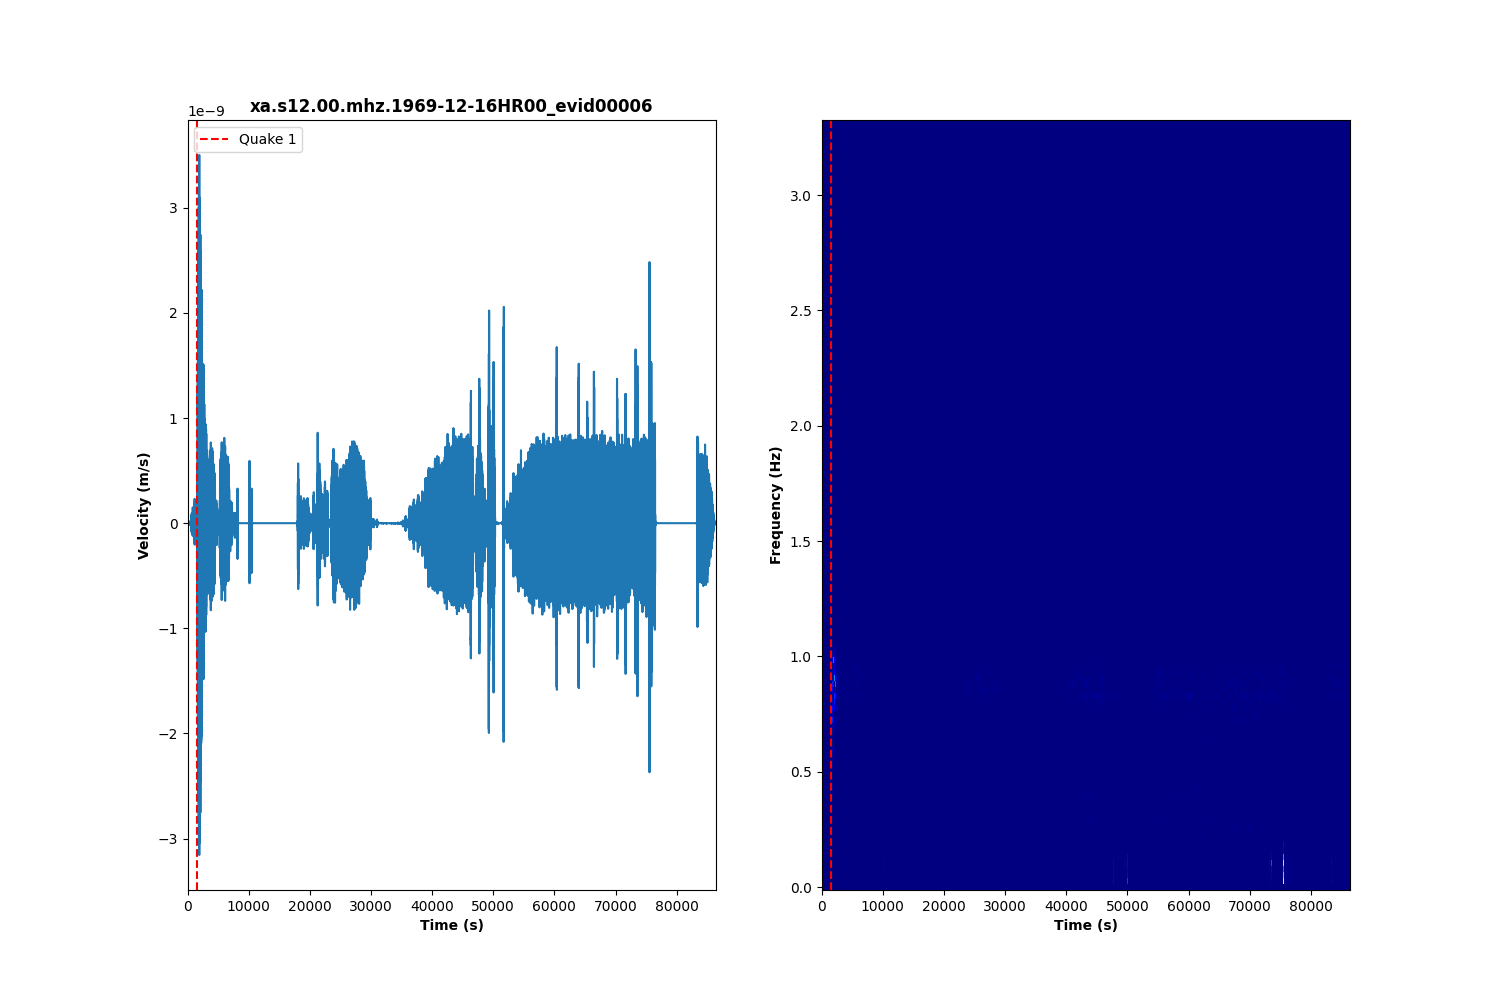

In [4]:
%matplotlib ipympl

x_coords_dict = {}

with open("test_data_catalog.csv", "r") as data:
    for i, line in enumerate(csv.reader(data)):
        if i == 0:
            continue
        x_coords_dict[line[0]] = eval(line[1])


lines_dict = {}

# Change this to the files you want to label:
file_paths = lunar_test_data_file_paths

current_file_index = 0
max_file_index = len(file_paths) - 1
current_quake_index = 0

def load_mseed_file(filepath):
    st = obspy.read(filepath)
    trace = st.traces[0].copy()
    times = trace.times()
    data = trace.data
    stats = trace.stats
    return times, data, stats

def visualise_file(ax1, ax2, filepath, title, quake_times=[]):
    times, data, stats = load_mseed_file(filepath)

    ax1.clear()
    ax1.plot(times, data)

    for i, quake_time in enumerate(quake_times):
        ax1.axvline(x=quake_time, color="red", linestyle="--", label=f"Quake {i + 1}")

    if quake_times:
        ax1.legend(loc="upper left")

    ax1.set_title(f"{title}", fontweight="bold")
    ax1.set_xlim((min(times), max(times)))
    ax1.set_ylabel("Velocity (m/s)", fontweight="bold")
    ax1.set_xlabel("Time (s)", fontweight="bold")

    f, t, sxx = signal.spectrogram(data, stats.sampling_rate)
    ax2.clear()  # Clear the previous spectrogram
    ax2.pcolormesh(t, f, sxx, cmap=cm.jet)

    for i, quake_time in enumerate(quake_times):
        ax2.axvline(x=quake_time, color="red", linestyle="--")

    ax2.set_xlim((min(times), max(times)))
    ax2.set_xlabel("Time (s)", fontweight="bold")
    ax2.set_ylabel("Frequency (Hz)", fontweight="bold")


def on_click(event):
    global current_quake_index, lines_dict, x_coords_dict
    if event.inaxes and event.button == 2:
        x = event.xdata
        current_file = os.path.basename(file_paths[current_file_index]).replace(".mseed", "")

        if current_file not in lines_dict:
            lines_dict[current_file] = []
            x_coords_dict[current_file] = []

        if current_quake_index >= 0 and current_quake_index < len(lines_dict[current_file]):
            # Update existing line
            lines_dict[current_file][current_quake_index].set_xdata([x, x])

        elif current_quake_index == len(lines_dict[current_file]):
            new_line = ax1.axvline(x=x, color="r", linestyle="--", label=f"Quake {current_quake_index + 1}")
            lines_dict[current_file].append(new_line)
            ax2.axvline(x=x, color="red", linestyle="--")

        x_coords_dict[current_file] = [line.get_xdata()[0] for line in lines_dict[current_file]]

        update_plot()
        ax1.legend(loc="upper left")

def on_press(event):
    global current_quake_index, current_file_index, lines_dict, x_coords_dict
    current_file = os.path.basename(file_paths[current_file_index]).replace(".mseed", "")

    if event.key in set(map(str, range(1, 10))):
        new_index = int(event.key) - 1
        if new_index <= len(lines_dict.get(current_file, [])):
            current_quake_index = new_index
        else:
            current_quake_index = -1  # Reset if out of bounds

    elif event.key == "delete":
        if current_file in lines_dict and current_quake_index >= 0 and current_quake_index < len(lines_dict[current_file]):
            lines_dict[current_file][current_quake_index].remove()
            del lines_dict[current_file][current_quake_index]
            del x_coords_dict[current_file][current_quake_index]
            current_quake_index = -1

            update_plot()

    elif event.key == "left" and current_file_index > 0:
        current_file_index -= 1
        current_quake_index = -1
        update_plot()

    elif event.key == "right" and current_file_index < max_file_index:
        current_file_index += 1
        current_quake_index = -1
        update_plot()

def update_plot():
    filepath = file_paths[current_file_index]
    current_file = os.path.basename(filepath).replace(".mseed", "")
    title = current_file

    quake_times = x_coords_dict.get(current_file, [])

    visualise_file(ax1, ax2, filepath, title, quake_times)
    plt.draw()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

fig.canvas.mpl_connect("button_press_event", on_click)
fig.canvas.mpl_connect("key_press_event", on_press)

visualise_file(ax1, ax2, file_paths[0], os.path.splitext(os.path.basename(file_paths[0]))[0])
update_plot()
plt.show()

In [5]:
import json

def write_test_data_catalog():
    with open("test_data_catalog.csv", "w", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["filename","time_rel(sec)"])
        for key, value in x_coords_dict.items():
            proper_list = json.loads(value)
            times = list(map(lambda x: float(x), proper_list))
            writer.writerow([key, times])

In [6]:
# write_test_data_catalog()

In [7]:
test_data_catalog = pd.read_csv("test_data_catalog.csv")

X = []
for file_path in test_data_file_paths + train_data_file_paths:
    row = {}
    times, data, _ = load_mseed_file(file_path)

    file_name = os.path.basename(file_path)
    file_name_withoud_evid = remove_evid_suffix(file_name)
    file_name_without_extension = file_name.replace(".mseed", "")

    row["filename"] = file_name
    row["filename_without_evid"] = file_name_withoud_evid
    row["times"] = times
    row["data"] = data
    row["time_rel"] = []

    if file_name_without_extension in lunar_catalog["filename"].to_list():
        found_row = lunar_catalog.loc[lunar_catalog["filename"] == file_name_without_extension]
        value = found_row["time_rel(sec)"].item()
        row["time_rel"].append(value)
    elif file_name in mars_catalog["filename"].to_list():
        found_row = mars_catalog.loc[mars_catalog["filename"] == file_name]
        value = found_row["time_rel(sec)"].item()
        row["time_rel"].append(value)
    elif file_name_without_extension in test_data_catalog["filename"].to_list():
        found_row = test_data_catalog.loc[
            test_data_catalog["filename"] == file_name_without_extension
        ]
        row["time_rel"] = found_row["time_rel(sec)"].item()

    X.append(row)

X = pd.DataFrame(X)

In [8]:
# empty entries
X[X["time_rel"].apply(len) == 0]

,filename,filename_without_evid,times,data,time_rel
96,XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed,XB.ELYSE.02.BHV.2019-05-23HR02,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[-0.0, 0.00019864462531553602, -0.001629949058...",[]
97,XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed,XB.ELYSE.02.BHV.2019-07-26HR12,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 6.686134029993153e-05, 5.67963073810348e...",[]
98,XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed,XB.ELYSE.02.BHV.2019-07-26HR12,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 6.686134029993153e-05, 5.67963073810348e...",[]
99,XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed,XB.ELYSE.02.BHV.2019-09-21HR03,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[-0.0, -0.0003477903789540691, -0.002021502907...",[]
100,XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed,XB.ELYSE.02.BHV.2021-05-02HR01,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0001445391690849273, 0.001533005468421...",[]
101,XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed,XB.ELYSE.02.BHV.2021-10-11HR23,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0008688291210824519, 0.006072897068275...",[]
102,XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed,XB.ELYSE.02.BHV.2021-12-24HR22,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.002882599716235456, 0.0054220651000912...",[]
103,XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed,XB.ELYSE.02.BHV.2022-04-09HR22,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.00028421692670263965, 0.00104010046988...",[]
104,XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed,XB.ELYSE.02.BHV.2022-05-04HR23,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0040756193600632535, 0.007310300940710...",[]


In [9]:
import ast

def fix_element(el):
    if isinstance(el, str):
        return ast.literal_eval(el)
    return el

X_fixed = X[X["time_rel"].apply(len) > 0].copy()
X_fixed["time_rel"] = X_fixed["time_rel"].apply(fix_element)

In [10]:
X_fixed

,filename,filename_without_evid,times,data,time_rel
0,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,xa.s12.00.mhz.1969-12-16HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[0.0, -5.57693957027173e-15, -1.11538791405434...",[1602.7656855833166]
1,xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed,xa.s12.00.mhz.1970-01-09HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[-1.0777682539631116e-14, -1.3543871789393292e...",[7352.079718734576]
2,xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed,xa.s12.00.mhz.1970-02-07HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[8.964501148314066e-15, 1.017825387324399e-14,...","[5499.912576092035, 12333.962584391873]"
3,xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed,xa.s12.00.mhz.1970-02-18HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[9.853050361742149e-14, 1.2330019737739196e-13...","[6131.678712149618, 43844.25223892913]"
4,xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed,xa.s12.00.mhz.1970-03-14HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[-9.446984331822866e-16, -1.214790402959833e-1...",[43339.25567802854]
...,...,...,...,...,...
178,xa.s12.00.mhz.1975-05-04HR00_evid00192.mseed,xa.s12.00.mhz.1975-05-04HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[8.378883424796289e-17, 7.740468608984878e-17,...",[36300.0]
179,xa.s12.00.mhz.1975-06-24HR00_evid00196.mseed,xa.s12.00.mhz.1975-06-24HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[1.1799114775093933e-14, 1.4887247521375698e-1...",[57780.0]
180,xa.s12.00.mhz.1975-06-26HR00_evid00198.mseed,xa.s12.00.mhz.1975-06-26HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[-1.932693410594629e-15, -2.417374307376486e-1...",[12240.0]
181,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed,XB.ELYSE.02.BHV.2022-01-02HR04,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0005027416016689591, 0.003634534277612...",[2130.0]


In [11]:
X_fixed.head()

,filename,filename_without_evid,times,data,time_rel
0,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,xa.s12.00.mhz.1969-12-16HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[0.0, -5.57693957027173e-15, -1.11538791405434...",[1602.7656855833166]
1,xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed,xa.s12.00.mhz.1970-01-09HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[-1.0777682539631116e-14, -1.3543871789393292e...",[7352.079718734576]
2,xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed,xa.s12.00.mhz.1970-02-07HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[8.964501148314066e-15, 1.017825387324399e-14,...","[5499.912576092035, 12333.962584391873]"
3,xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed,xa.s12.00.mhz.1970-02-18HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[9.853050361742149e-14, 1.2330019737739196e-13...","[6131.678712149618, 43844.25223892913]"
4,xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed,xa.s12.00.mhz.1970-03-14HR00,"[0.0, 0.1509433962264151, 0.3018867924528302, ...","[-9.446984331822866e-16, -1.214790402959833e-1...",[43339.25567802854]


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = X_fixed[["times", "data"]]
targets = X_fixed["time_rel"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.2, random_state=42
)